In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from PIL import Image
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast, GradScaler
from pytorch_ranger import Ranger
import csv
import string
import seaborn as sns
#from config import Config
import utils as utils
import network as network
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
import csv
import random
import warnings

warnings.filterwarnings("ignore")

/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-05-08 17:23:38.648769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 17:23:39.273479: W tensorflow/compiler/tf2tensorrt/utils/py_util

In [2]:
# set up cude if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Get the current working directory
current_directory = os.getcwd()

In [4]:
current_directory

'/home/lukas/Schreibtisch/JKU/Master/Semester 4/AI-Systems/Project'

In [5]:
# Get the current working directory
current_directory = os.getcwd()

# Specify the name of the data folder
data_folder_name = "archive"
train_data_csv = "sign_mnist_train.csv"
val_data_csv = "sign_mnist_test.csv"

# Construct the path to the data folder
data_folder_path = os.path.join(current_directory, data_folder_name)

train_data_csv_path = os.path.join(data_folder_path, train_data_csv)
val_data_csv_path = os.path.join(data_folder_path, val_data_csv)

print("Path to the 'data' folder:", data_folder_path)

Path to the 'data' folder: /home/lukas/Schreibtisch/JKU/Master/Semester 4/AI-Systems/Project/archive


In [6]:
train_data_csv_path

'/home/lukas/Schreibtisch/JKU/Master/Semester 4/AI-Systems/Project/archive/sign_mnist_train.csv'

In [7]:
training_images, training_labels = utils.parse_data_from_input(train_data_csv_path)
validation_images, validation_labels = utils.parse_data_from_input(val_data_csv_path)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


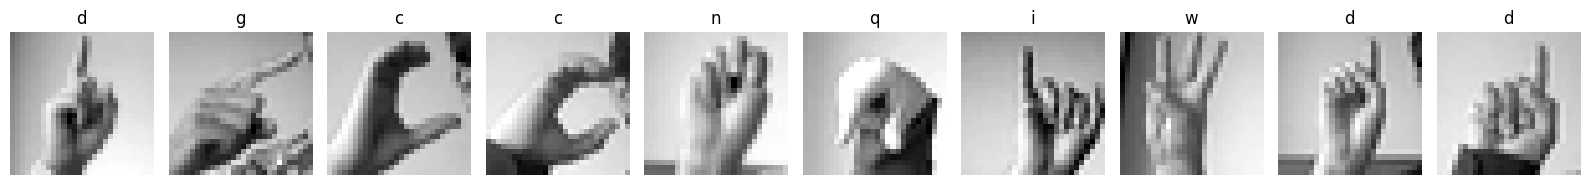

In [8]:
utils.plot_categories(training_images, training_labels)

In [9]:
# Define the required parameters for normalization
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
resize_size = 256
crop_size = 224

# Define custom transformation function
def custom_transform(image):
    # Convert numpy array to PIL Image
    image = Image.fromarray(np.uint8(image.squeeze()))
    return image

# Define transformation pipeline
train_transform = transforms.Compose([
    custom_transform,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=1),
    transforms.Resize(resize_size, interpolation=Image.BICUBIC),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])


val_transform = transforms.Compose([
    custom_transform,
    transforms.Resize(resize_size, interpolation=Image.BICUBIC),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

In [10]:
train_dataset = utils.CustomDataset(training_images, training_labels, train_transform)
val_dataset = utils.CustomDataset(validation_images, validation_labels, val_transform)

In [11]:
print(f"Length Train Dataset: {len(train_dataset)}")
print(f"Length Validation Dataset: {len(val_dataset)}")

Length Train Dataset: 27455
Length Validation Dataset: 7172


In [12]:
batch_size = 32 #128

train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size, drop_last=True)

In [13]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

In [14]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_model_frozen.pth'
epochs = 25
writer = SummaryWriter(log_dir="runs/experiment_frozen", comment='frozen')

# Initialize model, loss function, optimizer
model, _ = network.create_network(freeze_pretrained=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters())
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False)
                                              
# early stopping
patience = 5

# # Start the training loop
#utils.train(train_dataloader, val_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, scheduler, patience)

Initial Stats: 



Train Loss: 3.2773, Train Accuracy: 0.0338
Validation Loss: 3.2947, Validation Accuracy: 0.0587
--------------------------------------------------

Starting training: 



Epoch 5/25 ==> Train Loss: 2.5727, Train Accuracy: 0.5855 Validation Loss: 2.5221, Validation Accuracy: 0.5812


No improvement for 5 consecutive epochs. Stopping training.


In [15]:
model, _ = network.create_network(freeze_pretrained=False)
model.load_state_dict(torch.load('models/best_model_frozen.pth'))
model = model.to(device)

In [16]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_model_finetuned.pth'
epochs = 100
writer = SummaryWriter(log_dir="runs/experiment_finetuned", comment='finetuned')

# loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters())
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False)

# early stopping
patience = 10

# Start the training loop
utils.train(train_dataloader, val_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, scheduler, patience)

Initial Stats: 



Train Loss: 1.2594, Train Accuracy: 0.6397
Validation Loss: 1.6157, Validation Accuracy: 0.5698
--------------------------------------------------

Starting training: 



Epoch 5/100 ==> Train Loss: 0.2026, Train Accuracy: 0.9546 Validation Loss: 1.3613, Validation Accuracy: 0.7857


Epoch 10/100 ==> Train Loss: 0.1600, Train Accuracy: 0.9714 Validation Loss: 0.2640, Validation Accuracy: 0.9508


Epoch 15/100 ==> Train Loss: 0.1327, Train Accuracy: 0.9806 Validation Loss: 0.4918, Validation Accuracy: 0.9358


Epoch 20/100 ==> Train Loss: 0.0996, Train Accuracy: 0.9852 Validation Loss: 0.1061, Validation Accuracy: 0.9845


Epoch 25/100 ==> Train Loss: 0.0787, Train Accuracy: 0.9890 Validation Loss: 0.1709, Validation Accuracy: 0.9784


Epoch 30/100 ==> Train Loss: 0.0668, Train Accuracy: 0.9911 Validation Loss: 0.2000, Validation Accuracy: 0.9741


Epoch 35/100 ==> Train Loss: 0.0686, Train Accuracy: 0.9911 Validation Loss: 0.5260, Validation Accuracy: 0.9337


Epoch 40/100 ==> Train Loss: 0.0650, Train Accuracy: 0.9922 Validation Loss: 0.3434, Validation Accuracy: 0.9879


Epoch 45/100 ==> Train Loss: 0.0366, Train Accuracy: 0.9946 Validation Loss: 0.0475, Validation Accuracy: 0.9933


No improvement for 10 consecutive epochs. Stopping training.
